In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import normalize
from scipy.spatial.distance import cdist
import pickle


In [2]:
with open('data/script_df.pkl', 'rb') as f:
    movie_df = pickle.load(f)

In [3]:
with open('result/nmf_model.pkl', 'rb') as f:
    nmf_topic_vec, nmf, _, tfidf = pickle.load(f)

#### Prepare genre info

In [4]:
movie_df.iloc[1078]

genre                         [Horror.Mystery, Thriller, Drama]
script_url                      /scripts/What-Lies-Beneath.html
scripts       murky haze dark greens shaft prismed purple pa...
title                                         What Lies Beneath
Name: 1078, dtype: object

The genre in the data is not well formated. For example, '.' were used as seperator.  Replace '.' with '|' before convert them to dummies. Also merge 'Music' and 'Musical' into one genre.

In [5]:
def format_genre(genres):
    res = []
    for g in genres:
        g = g.strip().replace('.', '|')
        if g == 'Music':
            g = 'Musical'
        res.append(g)
    return '|'.join(res)

In [6]:
movie_df['genre'] = movie_df['genre'].apply(format_genre)

In [7]:
movie_df.iloc[1078]

genre                             Horror|Mystery|Thriller|Drama
script_url                      /scripts/What-Lies-Beneath.html
scripts       murky haze dark greens shaft prismed purple pa...
title                                         What Lies Beneath
Name: 1078, dtype: object

In [8]:
genre_dummies = movie_df['genre'].str.get_dummies(sep='|')

In [9]:
genre_dummies.columns

Index(['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime',
       'Drama', 'Family', 'Fantasy', 'Film-Noir', 'History', 'Horror',
       'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Short', 'Sport', 'Thriller',
       'War', 'Western'],
      dtype='object')

Check the correlation between genres

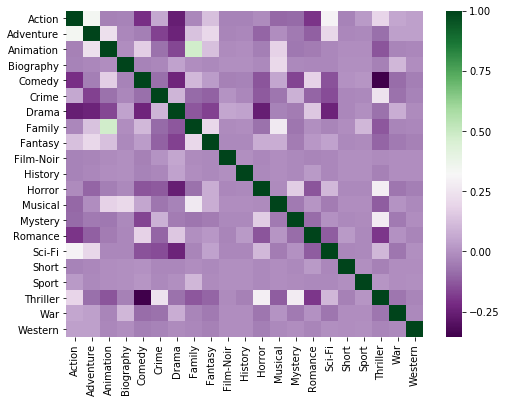

In [10]:
plt.figure(figsize=(8,6))
sns.heatmap(genre_dummies.corr(), cmap="PRGn");

In [11]:
pd.concat([genre_dummies.loc[movie_df['title'].str.contains('Shrek'), 'Family'], movie_df['title']], 
          join='inner', axis=1)

,Family,title
904,1,Shrek
905,0,Shrek the Third


** Genre 'Family' is defined not by the movie style, but audience. It shows correlation with 'Animation' and also the assignment of this genre is not consistent. For example, movie Shrek is under the 'Family' genre but the movie in the same sequel Shrek the Third is not. So remove genre 'Family' to avoid confusion.**  

In [12]:
genre_dummies.drop(columns='Family', inplace=True)

In [13]:
genre_tfidf = TfidfTransformer()
genre_vec = genre_tfidf.fit_transform(genre_dummies)

In [14]:
# show the idf vector.  Genre with low frequence has a larger scale.
genre_tfidf.idf_

array([2.30226895, 2.8263398 , 4.3304172 , 6.63300229, 2.12214279,
       2.67218912, 1.60093172, 3.28309821, 6.40985874, 6.63300229,
       2.98885873, 4.61809927, 3.30976645, 2.73609292, 2.92554645,
       6.63300229, 6.92068437, 2.07387605, 4.65200082, 5.31124645])

In [15]:
#normalize topic vector for each sample
nmf_topic_vec_normalized = normalize(nmf_topic_vec, norm='l1')

In [16]:
def similar_movie_by_title(movie_ind, topic_vec, genre_vec, scale):
    '''recommend top5 similiar movie to the input. 
    This function combines the topic vector with the genre vector 
    and return 5 movies with the smallest eucliean distance.
        Parameters
    ----------
    movie_ind : index of the movie in the matrix, int.

    topic_vec: The normalized nmf topic vector, shape[m,n]. m is movie number, n is topic number.
    
    genre_vec: tfidf transformed genre_vec, shape[m, k]. k is genre number
    
    scale: scale of the genre vec before combination. float.

    Returns
    -------
    movie_inds : indexs of the top movies, array, shape[5]
    '''
    movie_matrix = np.concatenate([topic_vec, genre_vec.toarray()*scale], axis=1)
    dist_array = cdist(movie_matrix[movie_ind].reshape(1, movie_matrix.shape[1]), movie_matrix, metric='euclidean')
    return np.argsort(dist_array)[0,1:6]

In [17]:
#movie 534 is Indiana Jones and the Last Crusade
m = similar_movie_by_title(534, nmf_topic_vec_normalized, genre_vec, 0.2)

In [18]:
movie_df['title'][m]

535     Indiana Jones and the Raiders of the Lost Ark
536              Indiana Jones and the Temple of Doom
245                               Clash of the Titans
723                                         The Mummy
1108                                              xXx
Name: title, dtype: object

In [19]:
# try different scale of genre vector
m = similar_movie_by_title(534, nmf_topic_vec_normalized, genre_vec, 0.7)

In [20]:
movie_df['title'][m]

535     Indiana Jones and the Raiders of the Lost Ark
536              Indiana Jones and the Temple of Doom
106                                      The Avengers
537                                  Indiana Jones IV
1108                                              xXx
Name: title, dtype: object

In addition to search for similar movie by title. We can take a text with movie plot, transform it to vectors using the save vocaluaries used in the tfidf, and combine the genre vector to get similar movies.

In [21]:
def similar_movie_by_text(text, query_genre, topic_vec, genre_vec, tfidf, genre_tfidf, nmf,  scale=0.5):
    '''recommend top5 similiar movie to the input text. 
    This function transform input text and genre using the same tfidf transformation for the database.
    Combines the topic vector with the genre vector 
    and return 5 movies with the smallest eucliean distance.
        Parameters
    ----------
    text: Text descript of the movie. String. 
    
    query_genre: binary 1D-array of the movie genry, shape(k). k is the genre number.

    topic_vec: The normalized nmf topic vector, shape[m,n]. m is movie number, n is topic number.
    
    genre_vec: tfidf transformed genre_vec, shape[m, k]. k is genre number
    
    tfidf: tfidf used in movie script transformation
    
    genre_tfidf: genre_tfidf used in genre transformation
    
    nmf: nmf used in topic formation
    
    scale: scale of the genre vec before combination. float.

    Returns
    -------
    movie_inds : indexs of the top movies, array, shape[5]
    '''
    query_vec = normalize(nmf.transform(tfidf.transform([text])), norm='l1').flatten()
    query_genre = genre_tfidf.transform(query_genre).toarray().flatten()
    query_vec_with_genre = np.concatenate([query_vec, query_genre*scale])
    movie_matrix= np.concatenate([topic_vec, genre_vec.toarray()*scale], axis=1)
    dist_array = cdist(query_vec_with_genre.reshape(1,-1), movie_matrix, metric='euclidean')
    return np.argsort(dist_array)[0,0:5]
    

In [22]:
# text of Wikipedia 'How to Train Your Dragon 3' Plot, which is to be released in Feb, 2019 
#and is not in the imsdb database yet
text = '''After becoming the chief of Berk, Hiccup has fulfilled his dream of creating a peaceful dragon utopia, while the sudden discovery of a wild, elusive mate lures Toothless away. When danger threatens their village and tests Hiccup's reign as chief, Hiccup and Toothless are forced to leave the only home they know. As they travel to a hidden world thought to only exist in myth, both dragon and rider will fight together to the very end to protect everything they love'''

In [23]:
#make the genre array, and set 'Adventure' and 'Animation' to 1
query_genre = np.zeros(genre_dummies.shape[1])
query_genre[[1,2]] = 1

In [24]:
n = similar_movie_by_text(text,query_genre, nmf_topic_vec_normalized, 
                           genre_vec, tfidf, genre_tfidf, nmf, scale=0.2)

In [25]:
movie_df['title'][n]

514    How to Train Your Dragon 2
513      How to Train Your Dragon
904                         Shrek
326                  Dragonslayer
37                        Aladdin
Name: title, dtype: object

It's great that we both movies in the sequel show up. 

Save the model and data for the app. 

In [26]:
with open('result/recommendation_model.pkl', 'wb') as f:
    pickle.dump((nmf_topic_vec_normalized, genre_vec, tfidf, genre_tfidf, nmf), f)

In [27]:
movie_titles = movie_df['title']

In [28]:
with open('result/movie_titles.pkl', 'wb') as f:
    pickle.dump(movie_titles, f)

In [29]:
movie_titles.to_csv('result/movie_list.csv', index=False)